In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For cleaning the abstract -> just for exploratory analysis
# !python -m spacy download en_core_web_sm
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
import string


# For an interactive dropdown menu that allows users to access
# all abstracts of NYT/Foxnews articles that were published in a given month
import ipywidgets as widgets
from IPython.display import display, clear_output

### 1. Load the metadata of climate change related articles

In [2]:
### Access the scraped data from the NYT & Fox news
### Download from github, so that external users (anyone without access to my local drive) can use the interactive widget too,
### *IF* they run the file on their local computer

def load_data(file_name):
    
    # Construct github URL where the csv file (metadata) is located
    base_url = 'https://raw.githubusercontent.com/quinnei/NLP-NYT-Foxnews/main/Data/'
    file_path = f"{base_url}{file_name}.csv"
    
    # Read in the csv file
    data = pd.read_csv(file_path) 
    
    # Convert the 'date' column to datetime
    data['date'] = pd.to_datetime(data['date'])
    
    return data

In [3]:
NYT = load_data('NYT')
foxnews = load_data('Foxnews')

### 2. Examine the distribution of the abstract length

In [4]:
### Count the number of words in the abstract
def count_words(text):
    return len(text.split())

### Plot a histogram
def plot_histogram(data, source):
    
    # Count the length of the abstract and convert to DataFrame
    abstract_length = data['abstract'].apply(count_words).to_frame(name = 'word_count')
    
    # Display summary statistics of abstract length
    print(f"Mean abstract length: {round(abstract_length['word_count'].mean(), 1)}")
    print(f"Min abstract length: {abstract_length['word_count'].min()}")
    print(f"Max abstract length: {abstract_length['word_count'].max()}")


    # Plot the histogram
    plt.figure(figsize = (6, 4))
    
    # Choose colors of the bars based on the news source
    color = 'royalblue' if source == 'NYT' else 'orangered'
    
    plt.hist(abstract_length['word_count'], color = color)
    plt.title(f'Distribution of abstract length: {source}', weight = 'bold')
    plt.xlabel('Length of the abstract')
    plt.ylabel('Number of articles')
    
    plt.savefig(f'2_Figures/abstract_length_{source}.png')
    plt.show()

Mean abstract length: 22.4
Min abstract length: 4
Max abstract length: 47


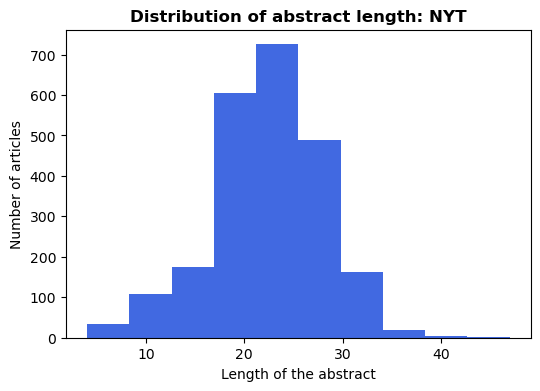

Mean abstract length: 26.4
Min abstract length: 3
Max abstract length: 74


In [5]:
plot_histogram(NYT, 'NYT')
plot_histogram(foxnews, 'Fox News')

### 3. Count the number of articles per month (2018-2022)

In [6]:
### Create a dataframe that keeps count of articles for each month

def count_articles(data):
    
    # Convert the 'date' variable to a datetime object
    data['date'] = pd.to_datetime(data['date'])

    # Group the data by year and month. Count the number of rows
    article_by_month = data.groupby(data['date'].dt.to_period('M')).size()
    
    # Remove the 'day' and keep only the 'year' & 'month'
    article_by_month.index = article_by_month.index.strftime('%Y-%m')
    
    # Convert the frequencies to a dataframe
    monthly_count = pd.DataFrame({
        # Create 2 columns - date & articles
        'Date': article_by_month.index,
        'Articles': article_by_month.values})
    
    return monthly_count

In [7]:
NYT_count = count_articles(NYT)
foxnews_count = count_articles(foxnews)

In [8]:
### Calculate the average number of articles published throughout the entire timeframe (2018-2022)

# Pair the dataframe (i.e. monthly count of articles) with the name of their respective news outlet
dataframes = [("NYT", NYT_count), ("Fox News", foxnews_count)]

# For NYT & Foxnews, print the average number of articles
for name, df in dataframes:
    average_num_articles = df['Articles'].mean()
    print(f"Average number of articles in {name}: {round(average_num_articles, 1)}")

Average number of articles in NYT: 38.8
Average number of articles in Fox News: 27.4


### 4. Plot a line graph

##### To see any sudden peaks/dips in the number of climate related news coverage:

In [9]:
### Define a function for adding annotations
    
def annotate_event(date, text, text_position, color):
    
    y_value = float(NYT_count[NYT_count['Date'] == date]['Articles'].iloc[0]) + 12

    plt.annotate(text, xy = (date, y_value), # where to draw arrow
                 # x, y coordinates of where to annotate
                 xytext = text_position,
                 # Add arrows
                 arrowprops = dict(arrowstyle = "->", connectionstyle = "arc3, rad = .06", color = color),
                 horizontalalignment = 'left', color = color, fontweight = 'bold')
    # Draw a vertical line at the year-month
    plt.axvline(x = date, color = color, linestyle = '--', linewidth = 1)

In [10]:
### Plot the line graph with annotations

plt.figure(figsize = (12, 6))

# Plot the number of NYT articles by month, with date on the x-axis, count on the y-axis
plt.plot(NYT_count['Date'],
         NYT_count['Articles'],
         label = 'NYT', marker = 'o', color = 'royalblue')

# Plot the number of Fox news articles
plt.plot(foxnews_count['Date'],
         foxnews_count['Articles'],
         label = 'Fox News', marker = 'o', color = 'orangered')

# Assign title and axes labels
plt.title('The extent of climate change news coverage: NYT vs. Fox News\n', weight = 'bold', size = 15)
plt.xlabel('\nYear and month', size = 13)
plt.ylabel('Number of articles', size = 13)

# Plot and store the current (monthly) x-ticks
plt.plot()
monthly_ticks = plt.xticks()[0]

# To avoid x-ticks being writen on top of one another,
# select tick labels for Jan/Mar/May/Jul/Sep/Nov of each year
bimonthly_ticks = monthly_ticks[::2]

# Apply the new x-tick labels
plt.xticks(bimonthly_ticks, rotation = 70)

# Annotate month during which the UN COP was held
cop_dates = ['2018-12', '2019-12', '2021-11', '2022-11']
for date in cop_dates:
    annotate_event(date, 'UN COP', (70, 72), 'forestgreen')
    
# Annotate heat/wildfires
wildfire_heatwave_dates = ['2018-09', '2020-09', '2021-07']
for date in wildfire_heatwave_dates:
    annotate_event(date, 'Heat/Wildfires', (24, 53), 'darkgoldenrod')

# Annotate reintroduction of the Green New Deal
annotate_event('2019-04', "Ocasio-Cortez's call for \nthe Green New Deal", (2, 50), 'midnightblue')

# Annotate September 2019 Democratic presidential debate
annotate_event('2019-09', 'Democratic presidential debate', ('2019-10', 75), 'midnightblue')

# Annotate inauguration of Joe Biden
annotate_event('2021-01', 'Inauguration of \nJoe Biden', ('2021-04', 62), 'midnightblue')

# Add legend on the upper left corner
plt.legend(loc = 'upper left')

plt.tight_layout()
plt.savefig('./2_Figures/number_of_articles.png')
plt.show()

### 5. Create a bar chart of the most frequent words in a given month

##### To examine the focus of the news coverage, in a given month:

In [11]:
### Add & remove stopwords

add_to_stopwords = {"climate", "change", "global", "warming", "warm", "environment", "environmental", "planet", "earth",
                    "study", "studies", "research", "report", "reporter", "analysis", "data", "datum", "according",
                    "work", "project", "plan", "program", "researcher", "expert", "scientist", "record", "source",
                    "people", "public", "thing", "community", "group", "region", "role", "method", "way", "road", "path",
                    "says", "said", "announce", "suggest", "suggests", "show", "shows", "explain", "explains", "explained", "release", "reveal", "find", "finds",
                    "know", "question", "answer", "think", "include", "mean", "means",
                    "propose", "expect", "reach", "come", "bring", "start", "create", "run",
                    "help", "continue", "want", "need", "require",
                    "like", "likely", "look", "looks", "nearly", "near", "away",
                    "fight", "combat", "address", "face", "action", "effort", "try", "challenge",
                    "impact", "effect", "affect", "meet", "reach", "goal", "aim", "objective",
                    "year", "month", "month", "week", "weeks", "days", "decade", "century", "ago", "time", "late", "early", "future", "past", "yesterday", "today", "tomorrow", "recent",
                    "monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday",
                    "hundred", "thousand", "million", "billion", "percent", "half", "quarter", "number",
                    "average", "common"}

# Combine default stopwords and my own. Convert to a list
my_stopwords = ENGLISH_STOP_WORDS.union(add_to_stopwords)
my_stopwords_list = list(my_stopwords)


### Search for the top ngrams, among articles that were published in a given year and month
### -> based on document frequency (the number of articles that contained a given word)

def get_top_ngrams(data, year, month, top_n = 15):
    
    # Filter the articles based on year and month if provided
    if year is not None and month is not None:
        filtered_data = data[(data['date'].dt.year == year) & (data['date'].dt.month == month)]
    else:
        # Use the full dataset if year and month are not provided
        filtered_data = data
    
    
    # Clean the abstracts of the articles
    def preprocess_text(text):
        
        # Convert to lowercase
        text = text.lower()
        
        # Define strings that I want to remove - punctuations and digits
        # This is to keep and to clean words such as 'COP26', 'COP28' -> 'COP' / 'E.P.A' -> 'EPA'
        translation_table = str.maketrans('', '', string.punctuation + string.digits)

        # Apply the translation table to clean the abstract
        text = text.translate(translation_table)
        
        return text


    cleaned_abstracts = filtered_data['abstract'].apply(preprocess_text)

    
    # Initialize the CountVectorizer:
    vectorizer = CountVectorizer(stop_words = my_stopwords_list, # with custom stopwords
                                 ngram_range = (1, 3), # with not only unigrams but also bigrams and trigrams
                                 binary = True) # for calculating *document* frequency

    # Apply the countvectorizer to the cleaned abstracts
    X = vectorizer.fit_transform(cleaned_abstracts)

    # Count how many documents contained a given word (i.e. document frequency)
    # Convert the matrix to a 1D array, to add as column
    document_frequency = np.ravel(X.sum(axis = 0))
    words = vectorizer.get_feature_names_out()
    ngrams = pd.DataFrame({
        "Words": words,
        "Document Frequency": document_frequency})

    # List the ngrams within articles published in a given year & month 
    # The most frequency occurring across documents = top
    top_ngrams = ngrams.sort_values(by = "Document Frequency", ascending = False).head(top_n)
    
    return top_ngrams.reset_index(drop = True)

In [12]:

def get_top_ngrams(data, year = None, month = None, top_n = 15):
    
    # Filter the articles based on year and month if provided
    if year is not None and month is not None:
        filtered_data = data[(data['date'].dt.year == year) & (data['date'].dt.month == month)]
    else:
        # Use the full dataset if year and month are not provided
        filtered_data = data
    
    
    # Clean the abstracts of the articles
    def preprocess_text(text):
        
        # Convert to lowercase
        text = text.lower()
        
        # Define strings that I want to remove - punctuations and digits
        # This is to keep and to clean words such as 'COP26', 'COP28' -> 'COP' / 'E.P.A' -> 'EPA'
        translation_table = str.maketrans('', '', string.punctuation + string.digits)

        # Apply the translation table to clean the abstract
        text = text.translate(translation_table)
        
        return text


    cleaned_abstracts = filtered_data['abstract'].apply(preprocess_text)

    
    # Initialize the CountVectorizer:
    vectorizer = CountVectorizer(stop_words = my_stopwords_list, # with custom stopwords
                                 ngram_range = (1, 3), # with not only unigrams but also bigrams and trigrams
                                 binary = True) # for calculating *document* frequency

    # Apply the countvectorizer to the cleaned abstracts
    X = vectorizer.fit_transform(cleaned_abstracts)

    # Count how many documents contained a given word (i.e. document frequency)
    # Convert the matrix to a 1D array, to add as column
    document_frequency = np.ravel(X.sum(axis = 0))
    words = vectorizer.get_feature_names_out()
    ngrams = pd.DataFrame({
        "Words": words,
        "Document Frequency": document_frequency})

    # List the ngrams within articles published in a given year & month 
    # The most frequency occurring across documents = top
    top_ngrams = ngrams.sort_values(by = "Document Frequency", ascending = False).head(top_n)
    
    return top_ngrams.reset_index(drop = True)

In [13]:
def plot_top_ngrams(year = None, month = None):
    
    # Construct a dataframe that stores most frequently occurring terms across articles
    top_ngrams_NYT = get_top_ngrams(NYT, year, month)
    top_ngrams_foxnews = get_top_ngrams(foxnews, year, month)

    fig, axs = plt.subplots(1, 2, figsize = (12, 5))
    
    # Set the title based on whether year and month are provided
    if year is not None and month is not None:
        fig.suptitle(f'Most frequent words: Articles published in {year}/{month}',
                     size = 14, fontweight = 'bold')
        filename = f'document_frequency_{year}_{month}.png'
    else:
        fig.suptitle('Most frequent words in NYT and Fox News, throughout 2018-2022',
                     size = 14, fontweight = 'bold')
        filename = 'document_frequency_corpus.png'
        
    
    # NYT plot: horizontal bar plot
    axs[0].barh(top_ngrams_NYT['Words'], # y-axis
                top_ngrams_NYT['Document Frequency'],
                # Specify the colors of the bars: for Left-leaning news outlet -> blue
                color ='royalblue')
    
    axs[0].invert_yaxis()
    axs[0].set_title('The New York Times', fontweight = 'bold')
    axs[0].set_xlabel('\nNumber of articles', fontweight = 'bold')
    axs[0].set_ylabel('Words', fontweight = 'bold')
    
    
    for i, label in enumerate(axs[0].get_yticklabels()):
        if i < 7:
            label.set_fontweight('bold')
            

            
    # Fox News plot: horizontal bar plot
    axs[1].barh(top_ngrams_foxnews['Words'], # y-axis
                top_ngrams_foxnews['Document Frequency'], # x-axis
                # Specify the colors of the bars: for Left-leaning news outlet -> blue; for Right-leaning -> red
                color = 'orangered')
    # Flip the y-axis so that the highest frequency comes at the top
    axs[1].invert_yaxis()
    axs[1].set_title('Fox News', fontweight = 'bold')
    axs[1].set_xlabel('\nNumber of articles', fontweight = 'bold')
    
    # Make the top 7 words bold
    for i, label in enumerate(axs[1].get_yticklabels()):
        if i < 7:
            label.set_fontweight('bold')

    plt.tight_layout()
    plt.savefig(f'./2_Figures/document_frequency_{filename}.png')


    plt.show()

#### a) Most frequent words in the entire corpus, throughout the entire timeframe

In [14]:
plot_top_ngrams()

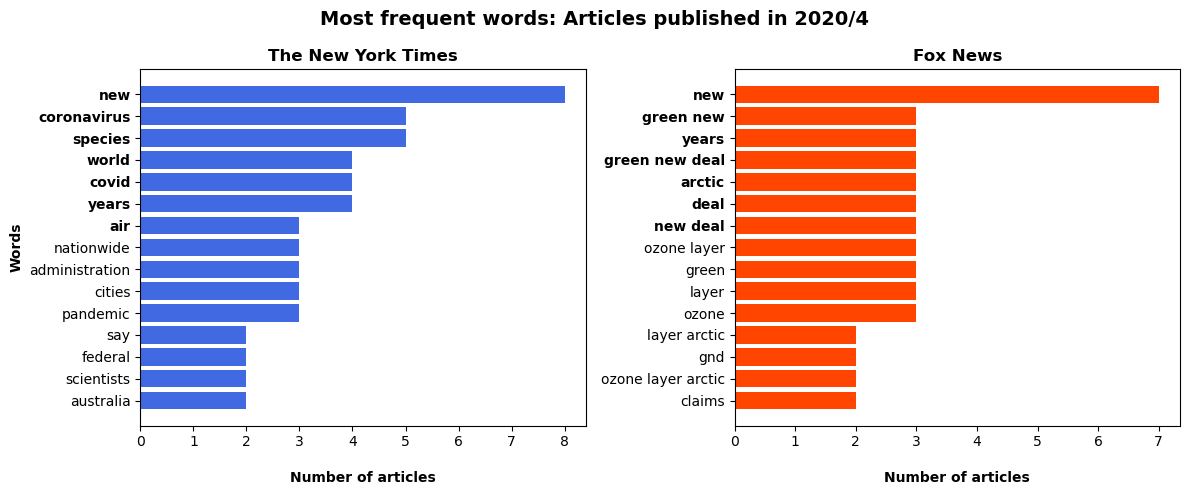

In [15]:
plot_top_ngrams(2020, 4) # California wildfires

#### b) Most frequent words, by month
##### When UN COP was hosted:

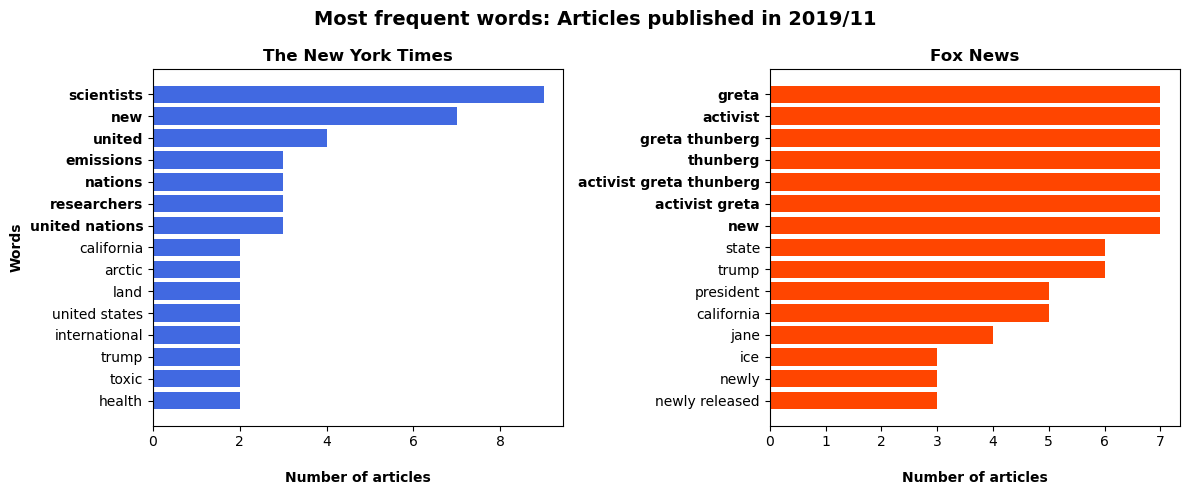

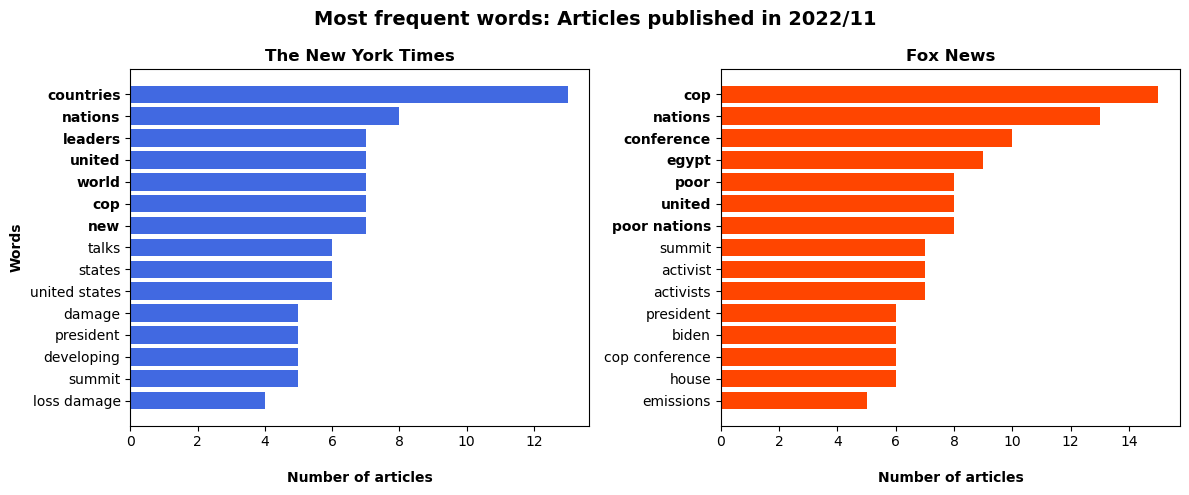

In [16]:
plot_top_ngrams(2018, 12)
plot_top_ngrams(2019, 11)
plot_top_ngrams(2021, 11)
plot_top_ngrams(2022, 11)

##### Peaks in the number of coverage for BOTH NYT & Foxnews

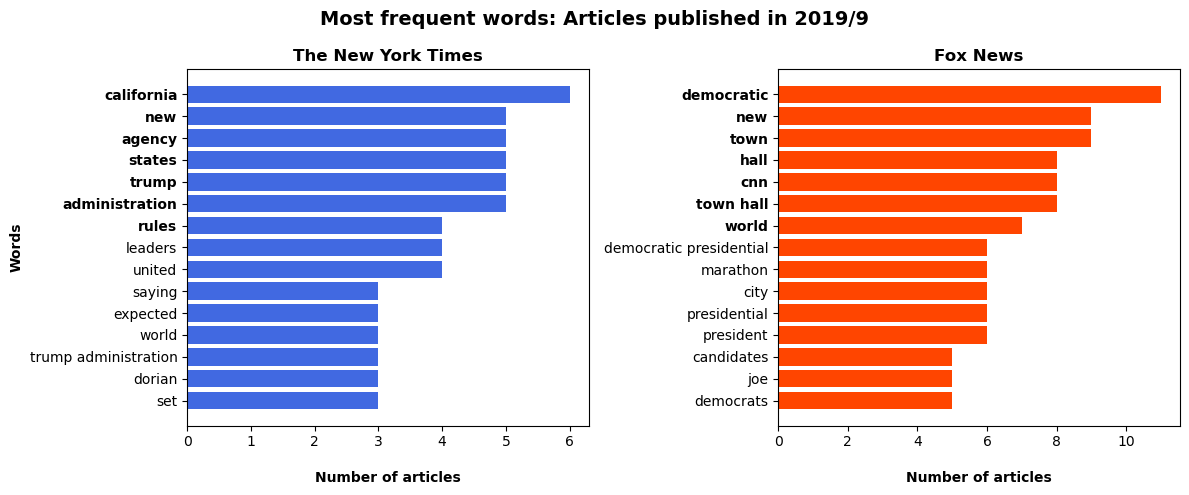

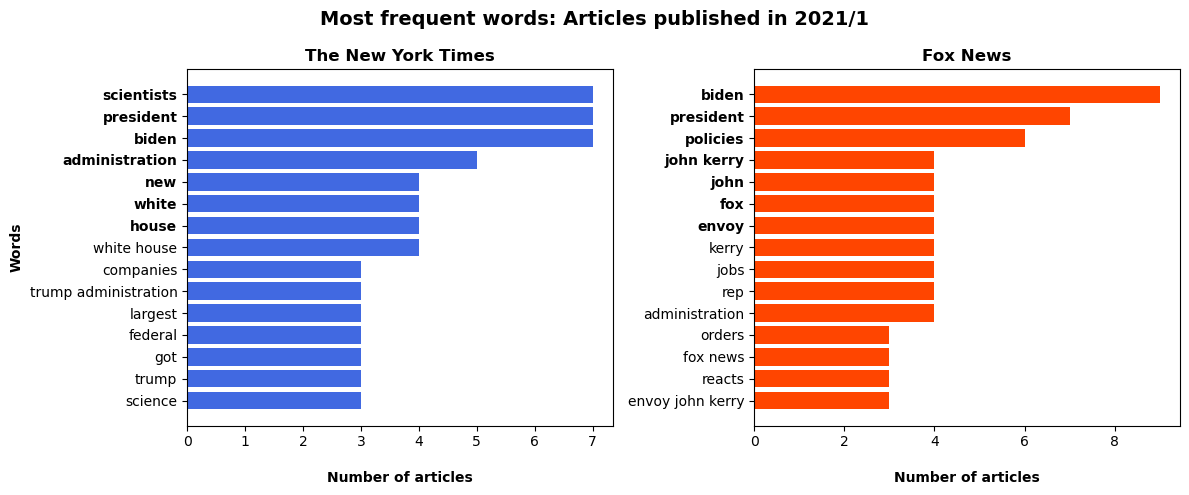

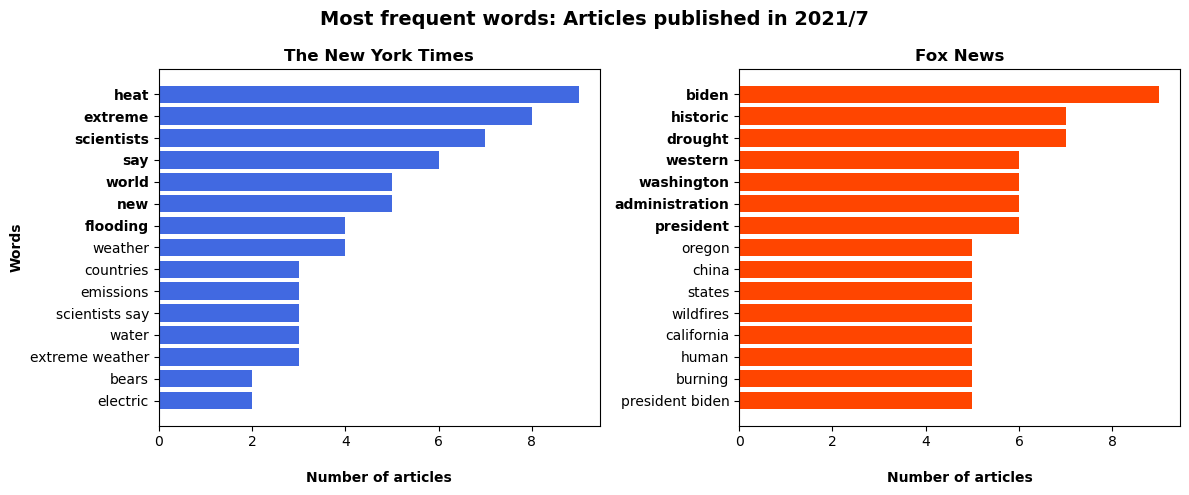

In [17]:
plot_top_ngrams(2019, 9) # September 2019 Democratic presidential debate
plot_top_ngrams(2020, 9) # California wildfires
plot_top_ngrams(2021, 1) # Inauguration of Joe Biden
plot_top_ngrams(2021, 7) # Extreme heat/wildfires

##### Noticeable peak ONLY FOR FOXNEWS

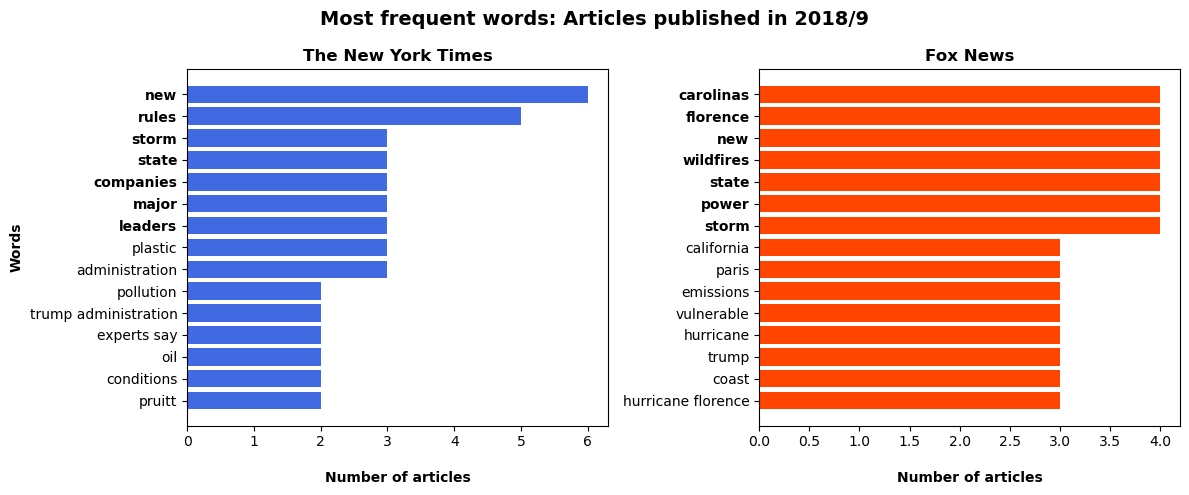

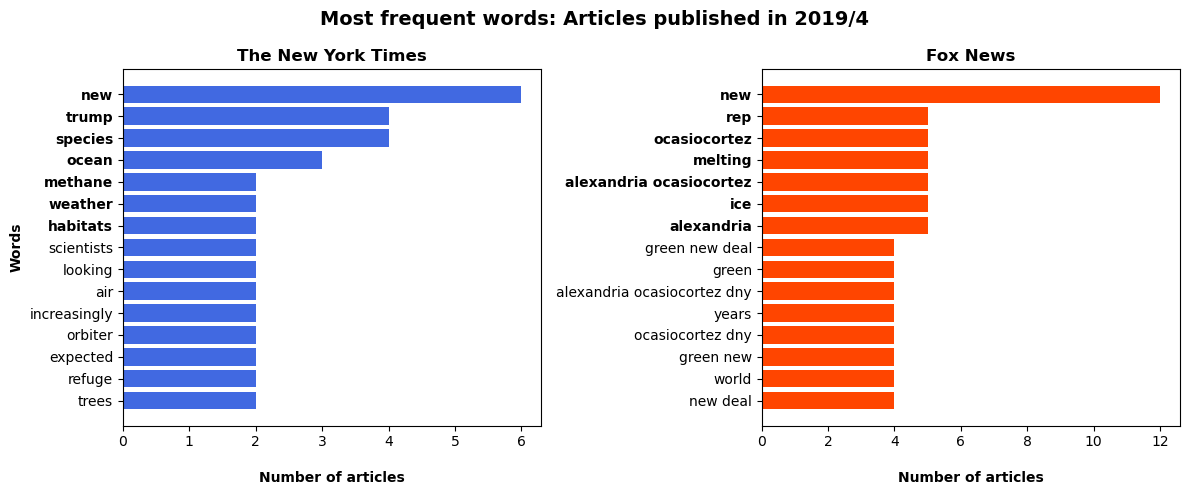

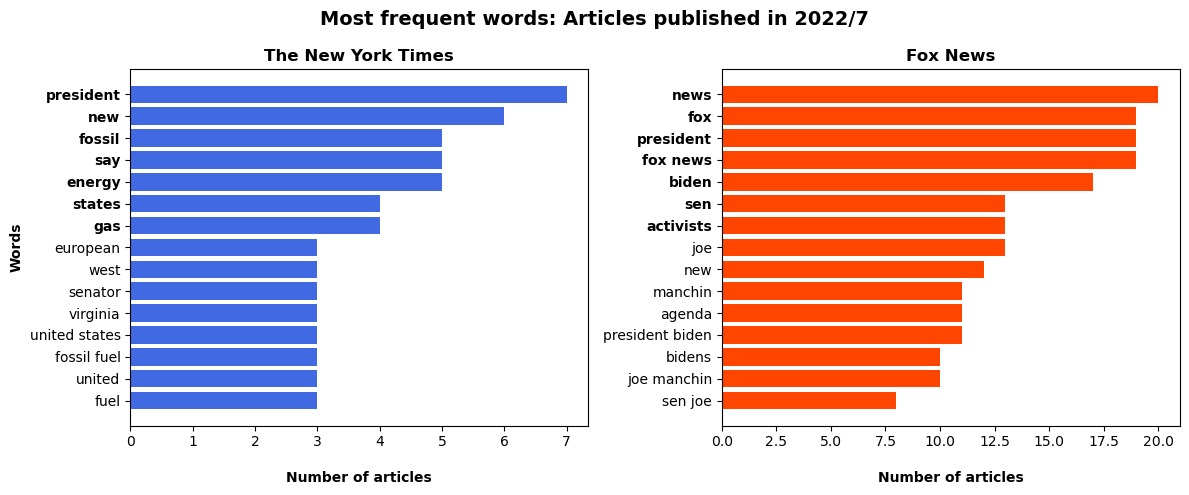

In [18]:
plot_top_ngrams(2018, 9) # California wildfires
plot_top_ngrams(2019, 4) # Republican Alexandria Ocasio-Cortez
plot_top_ngrams(2022, 7)

### 6. Retrieve abstracts based on the month in which the articles were posted

##### To examine any patterns in climate change coverage during months for which there are unusual peaks/dips in the number of articles posted

In [19]:
### Create a dropdown menu based on the year & month of publication

def create_dropdown(dataframe):
    
    # Extract year-month as a string
    dataframe['year_month'] = dataframe['date'].dt.strftime('%Y-%m')

    ### Create a dropdown widget with unique year-months combination
    dropdown = widgets.Dropdown(
        options = sorted(dataframe['year_month'].unique()),
        description = 'Select Month:',
        disabled = False,
    )

    # Create a widget that displays all article abstracts of a given month
    output = widgets.Output(layout = {'height': '300px', 'overflow': 'scroll'})

    
    ### Upon selection of new date range, remove previous output and retrieve new output
    def refresh_upon_new_selection(change):
        if change['type'] == 'change' and change['name'] == 'value':
            with output:
                clear_output()
                selected_month = change['new']
                
                # Filter dataframe based on the selected month
                selected_data = dataframe[dataframe['year_month'] == selected_month]
                
                # Display all abstracts from the selected month
                for abstract in selected_data['abstract']:
                    # Separate each abstract with dashes, for readability
                    print(abstract)
                    print("---")

    dropdown.observe(refresh_upon_new_selection)

    # Display results
    display(dropdown, output)

#### [For NYT] Select month and year of interest:

In [20]:
create_dropdown(NYT)

Dropdown(description='Select Month:', options=('2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06…

Output(layout=Layout(height='300px', overflow='scroll'))

#### [For Fox News] Select month and year of interest:

In [21]:
create_dropdown(foxnews)

Dropdown(description='Select Month:', options=('2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06…

Output(layout=Layout(height='300px', overflow='scroll'))

### For R shiny: Dataset creation

#### Create a csv file containing top 15 ngrams for each news source, for every month

In [22]:
# Generate all year-month combinations from 2018 to 2022
start_date = pd.to_datetime('2018-01-01')
end_date = pd.to_datetime('2022-12-31')
date_range = pd.date_range(start_date, end_date, freq = 'MS')

# Initialize empty dataframes to store top 15 ngrams per month
# Initialize empty DataFrame to store top ngrams per month
all_ngrams = pd.DataFrame()

# For each year-month combination
for date in date_range:
    year, month = date.year, date.month

    # Filter data by month
    NYT_monthly_data = NYT[(NYT['date'].dt.year == year) & (NYT['date'].dt.month == month)]
    foxnews_monthly_data = foxnews[(foxnews['date'].dt.year == year) & (foxnews['date'].dt.month == month)]

    # Get top ngrams for each dataset
    NYT_ngrams = get_top_ngrams(NYT_monthly_data)
    foxnews_ngrams = get_top_ngrams(foxnews_monthly_data)

    # Add columns to indicate source
    NYT_ngrams['Source'] = "The New York Times"
    foxnews_ngrams['Source'] = "Fox News"

    # Create a 'Date' column with year-month format
    formatted_date = date.strftime('%Y-%m')
    NYT_ngrams['Date'] = formatted_date
    foxnews_ngrams['Date'] = formatted_date

    # Append the results
    all_ngrams = pd.concat([all_ngrams, NYT_ngrams, foxnews_ngrams])

# Reorder the columns so that 'Date' and 'Source' come first
all_ngrams = all_ngrams[['Date', 'Source', 'Words', 'Document Frequency']]


all_ngrams.to_csv("./1_Data/top_ngrams_monthly.csv", index = False)